# WeightWatcher ResNet

https://calculationconsulting.com

### Analysis of pyTorch 

In [ ]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [ ]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Import WeightWatcher

set custom Logging at WARN Level

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARN)

import weightwatcher as ww
import torchvision.models as models

ww.__version__


### Create all models now

In [ ]:

series_name = 'ResNet'
all_names = [ 'resnet18', 'resnet34', 'resnet50', 'resnet101','resnet152']

colors = ['blue', 'green', 'teal', 'orange', 'red']


In [ ]:


all_models = []
all_models.append(models.resnet18(pretrained=True))
all_models.append(models.resnet34(pretrained=True))
all_models.append(models.resnet50(pretrained=True))
all_models.append(models.resnet101(pretrained=True))
all_models.append(models.resnet152(pretrained=True))




### Get reported accuracies from pytorch website

https://pytorch.org/docs/stable/torchvision/models.html

<pre>
<table class="docutils align-default">
<colgroup>
<col style="width: 55%" />
<col style="width: 22%" />
<col style="width: 22%" />
</colgroup>
<thead>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>Top-1 error</p></th>
<th class="head"><p>Top-5 error</p></th>
</tr>
</thead>
<tbody>

<tr class="row-odd"><td><p>ResNet-18</p></td>
<td><p>30.24</p></td>
<td><p>10.92</p></td>
</tr>
<tr class="row-even"><td><p>ResNet-34</p></td>
<td><p>26.70</p></td>
<td><p>8.58</p></td>
</tr>
<tr class="row-odd"><td><p>ResNet-50</p></td>
<td><p>23.85</p></td>
<td><p>7.13</p></td>
</tr>
<tr class="row-even"><td><p>ResNet-101</p></td>
<td><p>22.63</p></td>
<td><p>6.44</p></td>
</tr>
<tr class="row-odd"><td><p>ResNet-152</p></td>
<td><p>21.69</p></td>
<td><p>5.94</p></td>
</tr>

</tbody>
</table>
</pre>

In [ ]:
top1_errors= {
    
    "resnet18": 30.24,
    "resnet34": 26.70,
    "resnet50": 23.85,
    "resnet101": 22.63,
    "resnet152": 21.69 

}

In [ ]:
top5_errors= {
    
    "resnet18": 10.92,
    "resnet34": 8.58,
    "resnet50": 7.13,
    "resnet101": 6.44,
    "resnet152": 5.94    

}

## Run WeightWatcher, collect summary and details (as dataframes) for all models

In [ ]:
all_details = []
all_summaries = []
for im, name in enumerate(all_names):
    watcher = ww.WeightWatcher(model=all_models[im], logger=logger)
    results = watcher.analyze(alphas=True, softranks=True, spectralnorms=True, mp_fit=True)

    summary =  watcher.get_summary()
    all_summaries.append(summary)
    details  = watcher.get_details(results=results)
    details.drop(columns=['slice', 'slice_count'], inplace=True)
    details.dropna(inplace=True)
    details['NxM'] = pd.to_numeric(details.N * details.M)

    all_details.append(details)

In [251]:
plt.rcParams.update({'font.size': 16})
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

In [252]:
summary

{'norm': 3.0527217,
 'norm_compound': 5.0350556,
 'lognorm': 0.412757,
 'lognorm_compound': 0.6175736,
 'alpha': 2.724559949131712,
 'alpha_compound': 2.9469419656581795,
 'alpha_weighted': -0.7898082682877487,
 'alpha_weighted_compound': 0.04027351053082186,
 'spectralnorm': 0.8399572,
 'spectralnorm_compound': 1.5370497,
 'softrank': 17.4049847668072,
 'softrank_compound': 22.562603526409276,
 'softranklog': 1.1342460662040867,
 'softranklog_compound': 1.2625866063824769,
 'softranklogratio': -8.478652997106503,
 'softranklogratio_compound': -24.350396968023215,
 'sigma_mp': 0.7714098923141892,
 'sigma_mp_compound': 0.5238230776769714,
 'numofSpikes': 7.596396396396396,
 'numofSpikes_compound': 27.2,
 'ratio_numofSpikes': 0.02940427364799917,
 'ratio_numofSpikes_compound': 0.10528627015896477,
 'softrank_mp': 6.742674422513751,
 'softrank_mp_compound': 2.818981909101577,
 'logpnorm': -0.27331489544784365,
 'logpnorm_compound': 0.6392177610712281}

## Metrics vs Test Accuracy

In [253]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [254]:

def plot_test_accuracy(metric, xlabel, title):
    """Create plot of Metric vs Reported Test Accuracy, and run Linear Regression"""
    num = len(all_names)
    xs, ys = np.empty(num), np.empty(num)
    for im, modelname in enumerate(all_names):    

        summary = all_summaries[im]
        x = summary[metric]
        xs[im] = x

        error = top1_errors[modelname]
        y = 100.0-error
        ys[im] = y

        label = modelname
        plt.scatter(x, y, label=label)


    xs = xs.reshape(-1,1)
    ys = ys.reshape(-1,1)
    regr = linear_model.LinearRegression()
    regr.fit(xs, ys)
    y_pred = regr.predict(xs)
    plt.plot(xs, y_pred, color='red', linewidth=1)

    rmse = np.sqrt(metrics.mean_squared_error(ys, y_pred))
    r2 = metrics.r2_score(ys, y_pred)
    title2 = "RMSE: {0:.2}   R2: {0:.2}".format(rmse, r2)
    
    plt.legend()
    plt.title(r"Test Accuracy vs "+title+"\n"+title2)
    plt.ylabel(r"Test Accuracy")
    plt.xlabel(xlabel);
    plt.show()


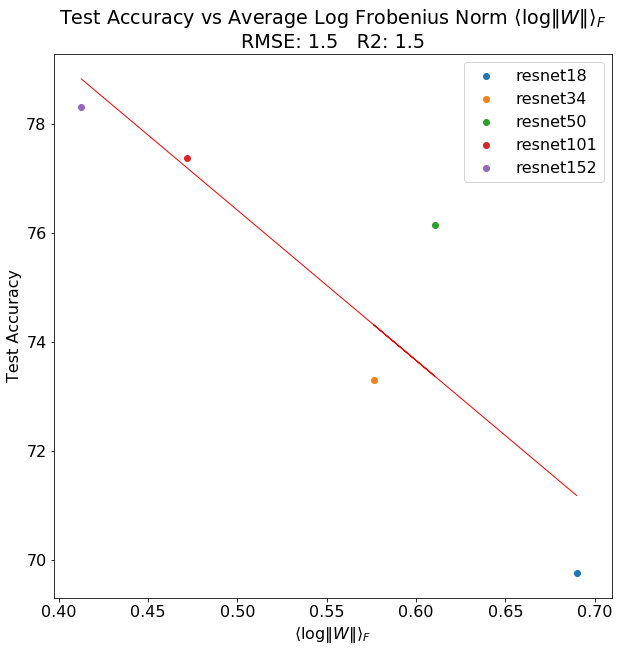

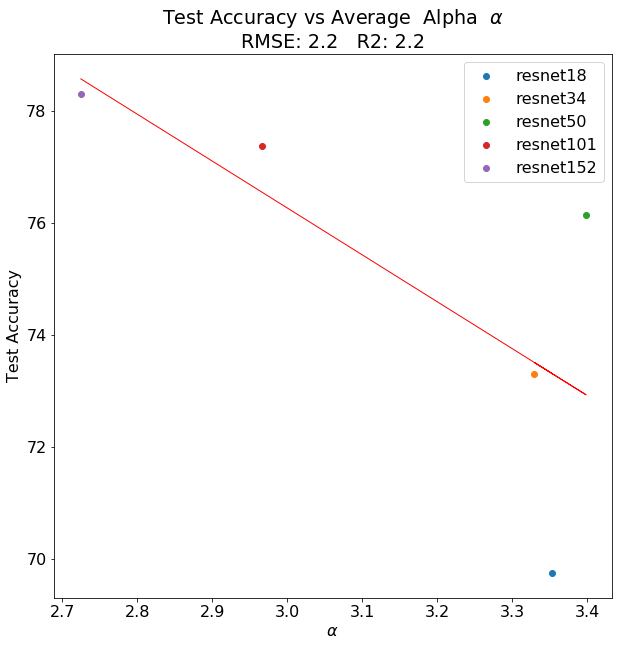

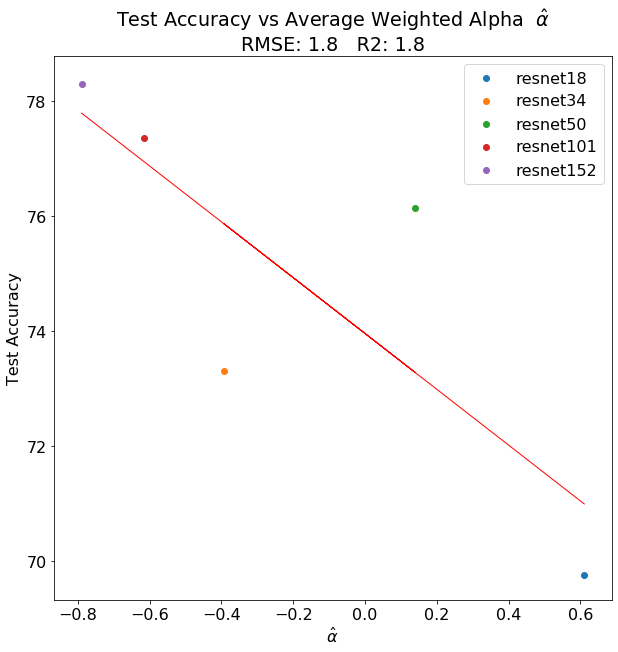

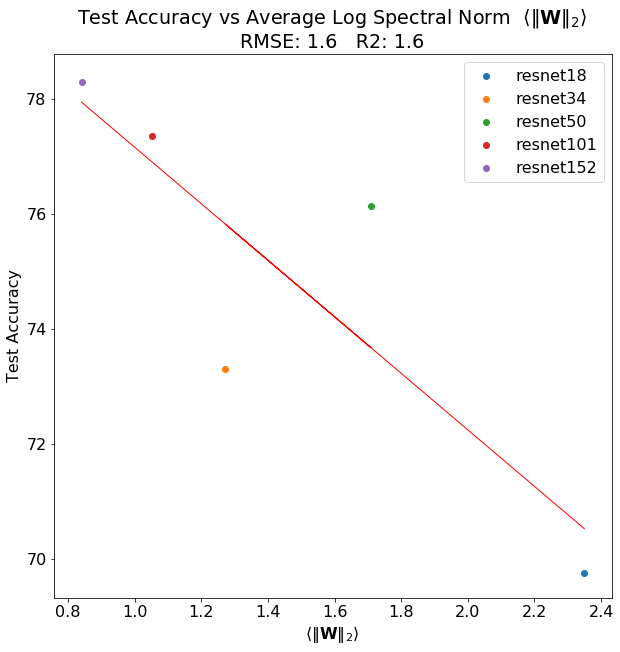

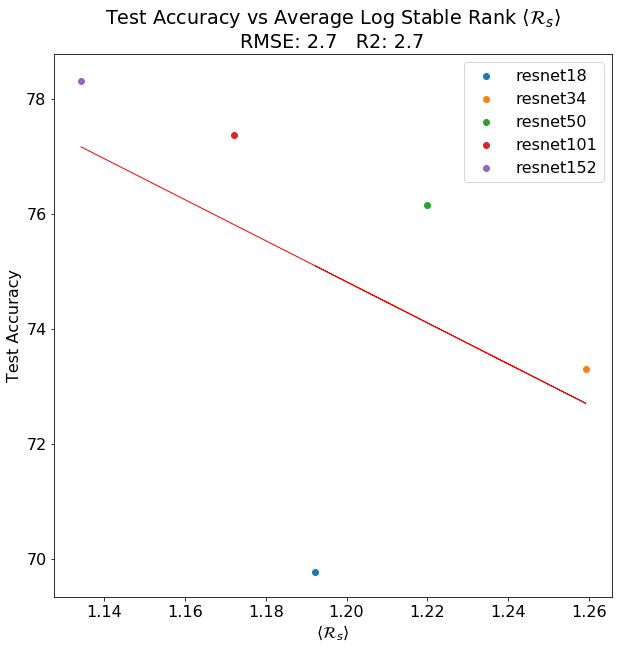

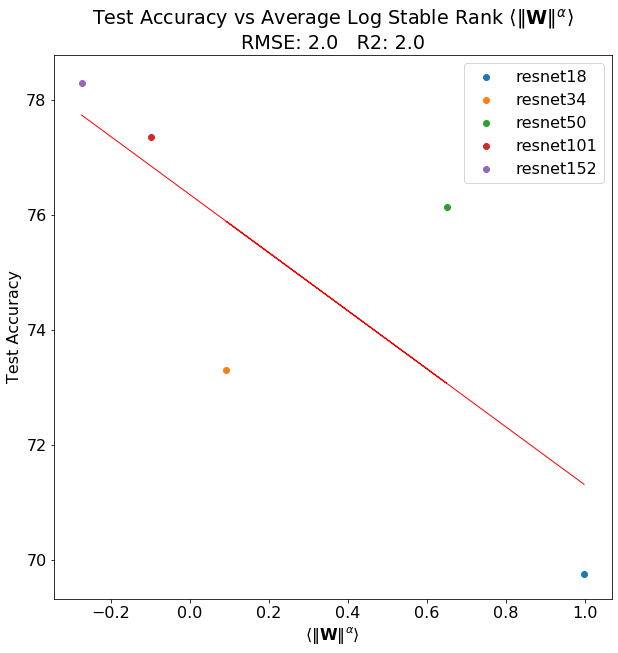

In [255]:
metric = "lognorm"
xlabel = r"$\langle\log\Vert W\Vert\rangle_{F}$"
title = "Average Log Frobenius Norm "+xlabel
plot_test_accuracy(metric, xlabel, title)


metric = "alpha"
xlabel = r"$\alpha$"
title = "Average  Alpha  "+xlabel
plot_test_accuracy(metric, xlabel, title)

metric = "alpha_weighted"
xlabel = r"$\hat{\alpha}$"
title = "Average Weighted Alpha  "+xlabel
plot_test_accuracy(metric, xlabel, title)

metric = "spectralnorm"
xlabel = r"$\langle\Vert\mathbf{W}\Vert_{2}\rangle$"
title = "Average Log Spectral Norm  "+xlabel
plot_test_accuracy(metric, xlabel, title)

metric = "softranklog"
xlabel = r"$\langle\mathcal{R}_{s}\rangle$"
title = "Average Log Stable Rank "+xlabel
plot_test_accuracy(metric, xlabel, title)

metric = "logpnorm"
xlabel = r"$\langle\Vert\mathbf{W}\Vert^{\alpha}\rangle$"
title = "Average Log Stable Rank "+xlabel
plot_test_accuracy(metric, xlabel, title)

## Histogram of metrics for all layers

In [259]:
def plot_metrics_histogram(metric, xlabel, title, log=False, valid_ids = []):
    transparency = 1.0
    
    if len(valid_ids) == 0:
        valid_ids = range(len(all_details)-1)
        
    for im, details in enumerate(all_details):
        if im in valid_ids:
            vals = details[metric].to_numpy()
            if log:
                vals = np.log10(np.array(vals+0.000001, dtype=np.float))

            plt.hist(vals, bins=100, label=all_names[im], alpha=transparency, color=colors[im], density=True)
            transparency -= 0.15

    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

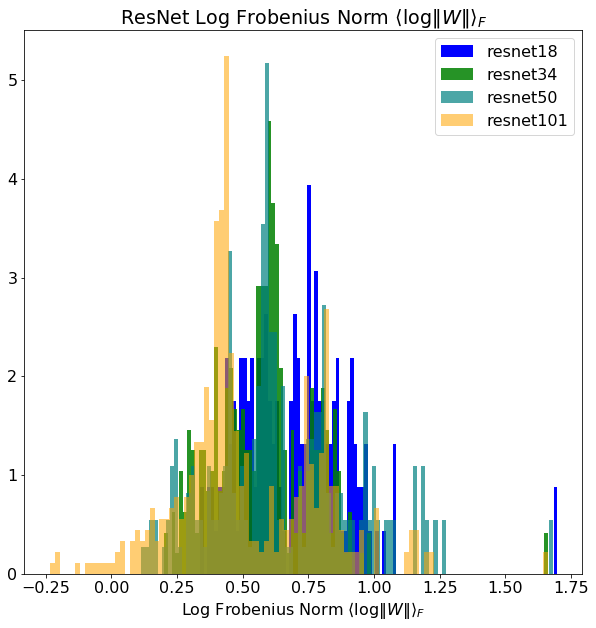

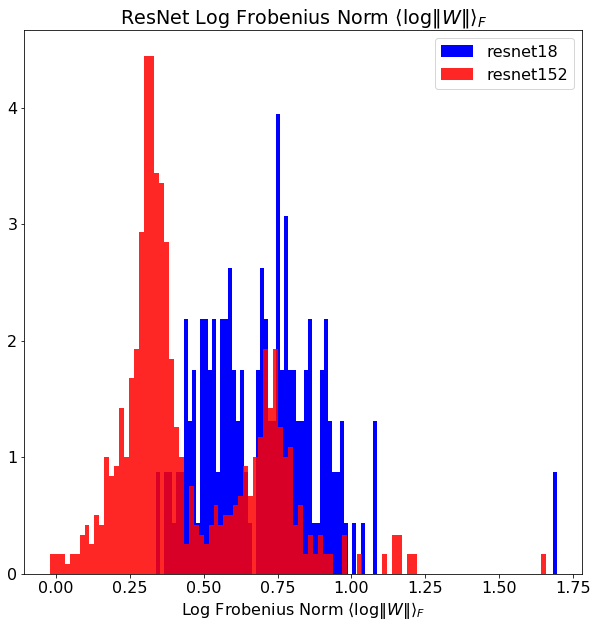

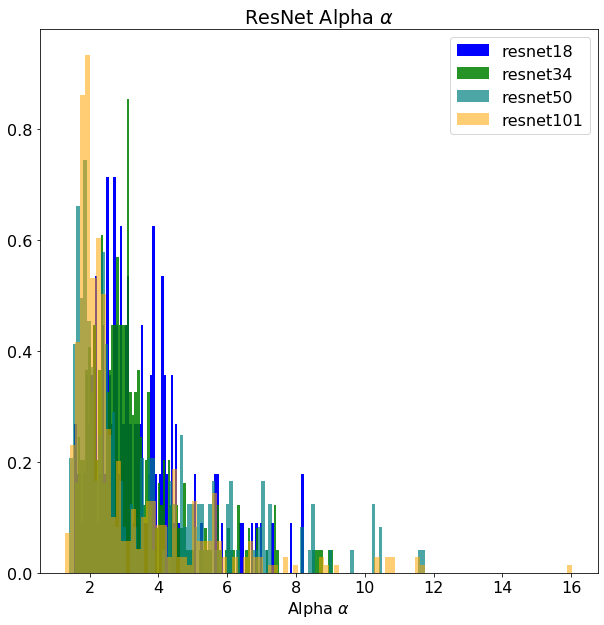

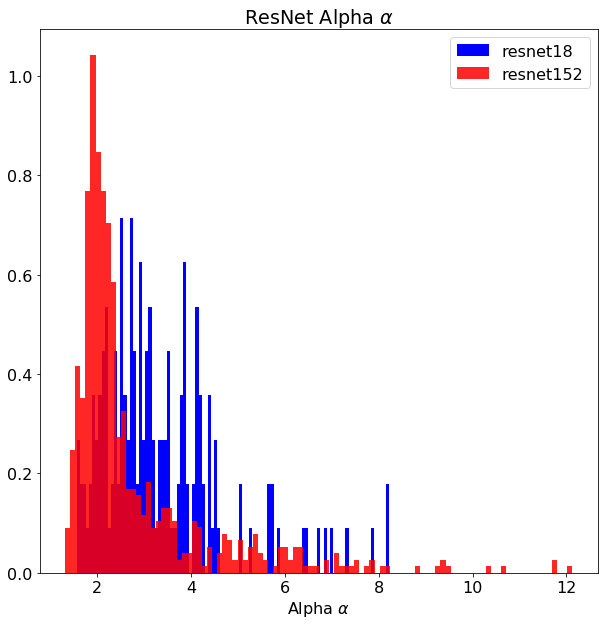

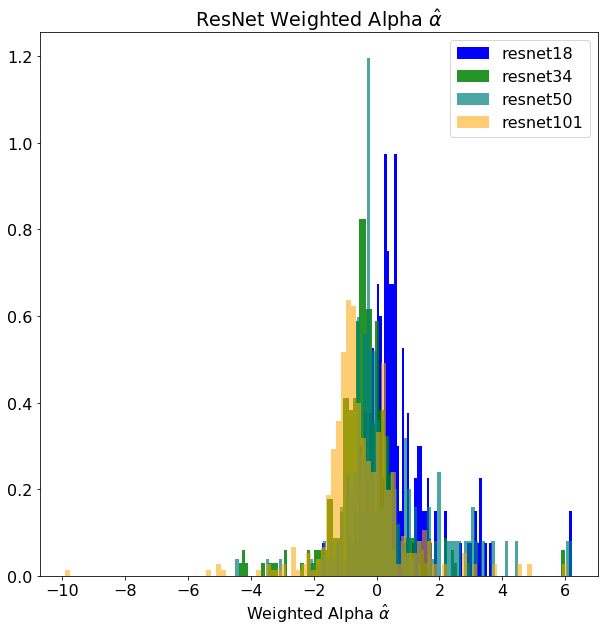

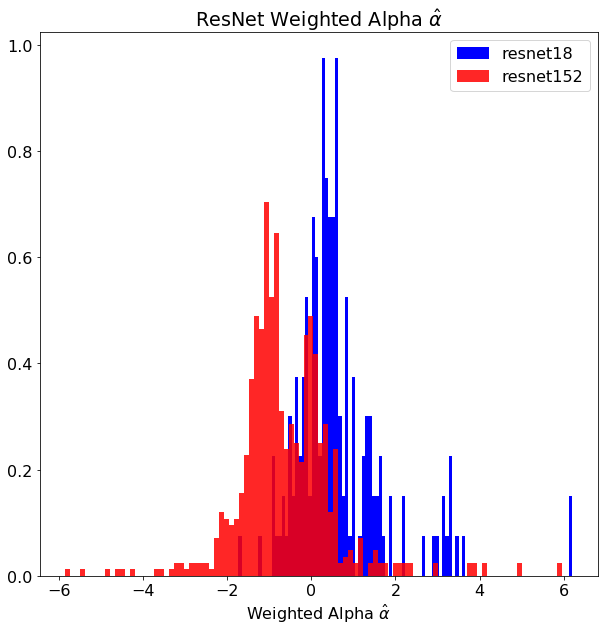

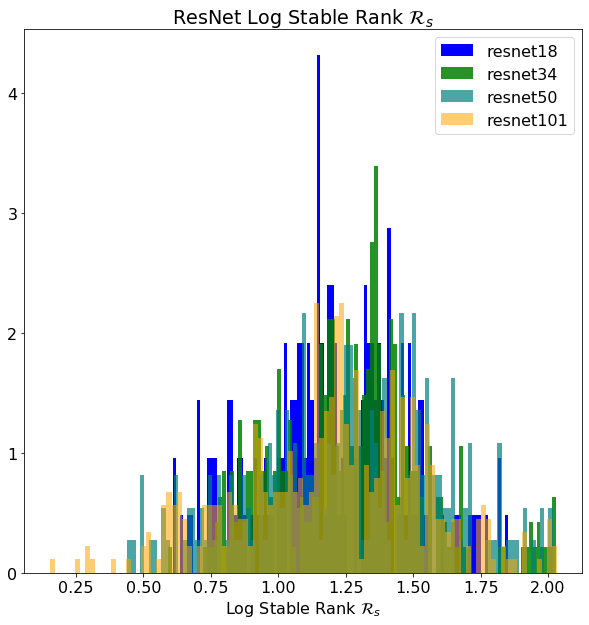

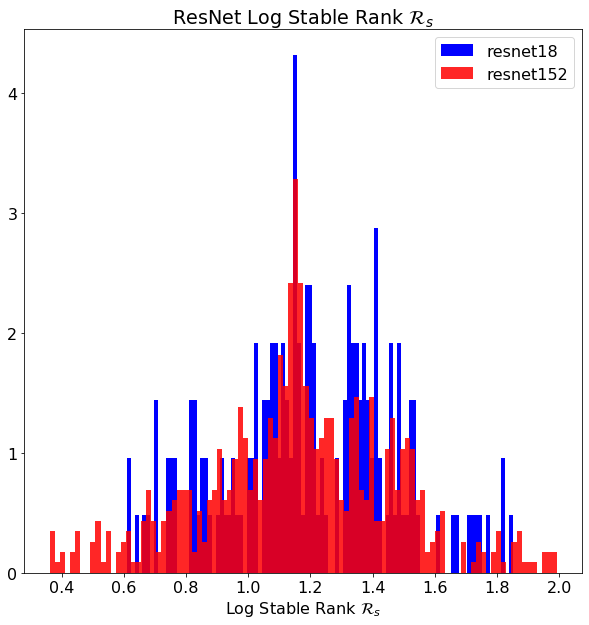

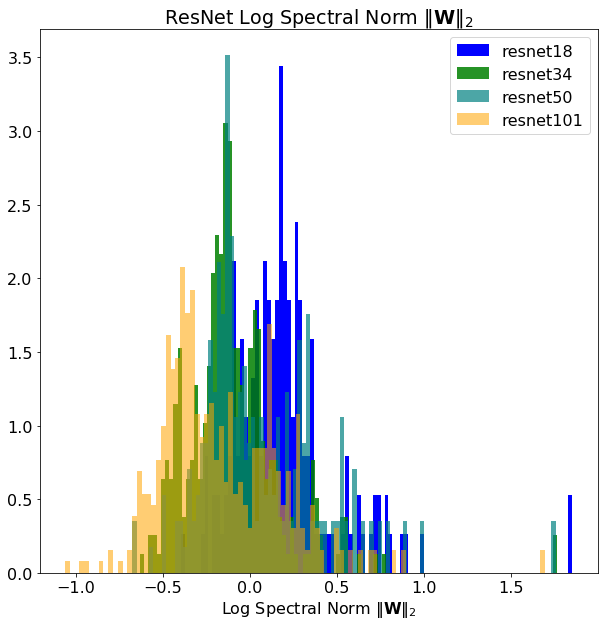

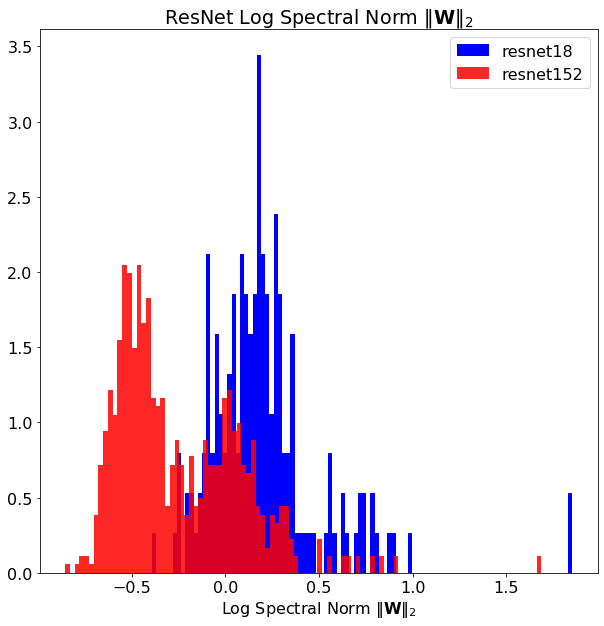

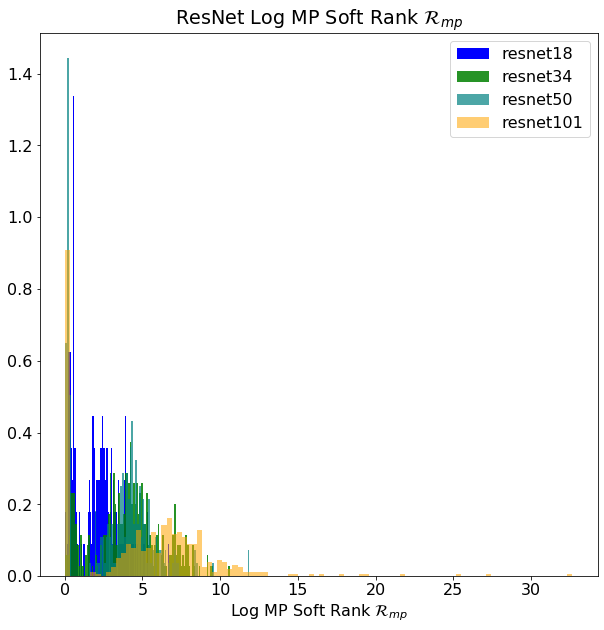

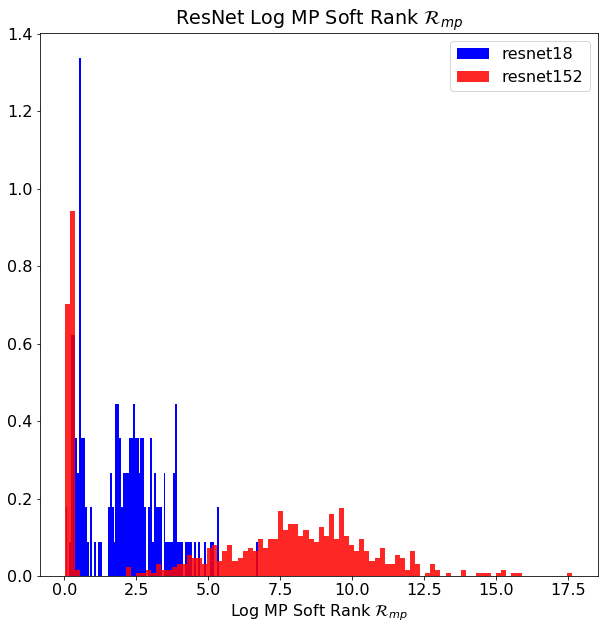

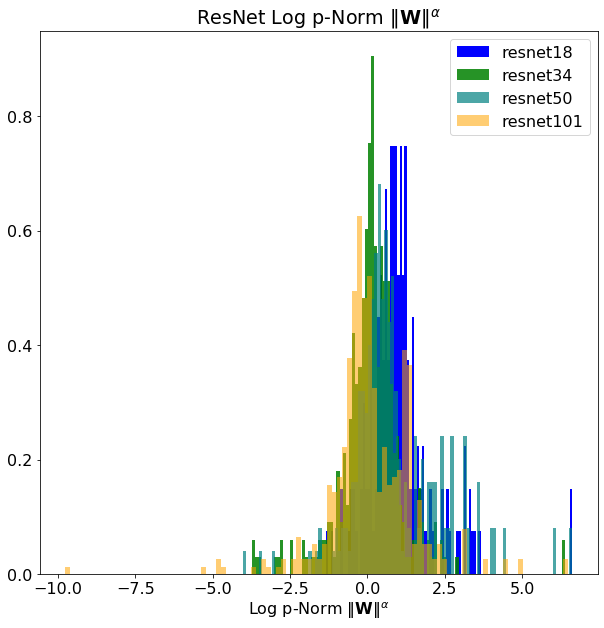

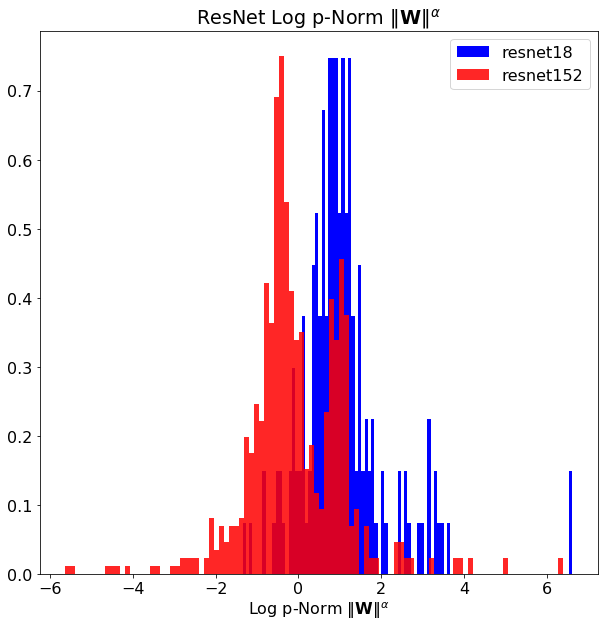

In [260]:
first_n_last_ids = [0, len(all_details)-1]
metric = "lognorm"
xlabel = r"Log Frobenius Norm $\langle\log\Vert W\Vert\rangle_{F}$"
title = series_name+" "+xlabel
plot_metrics_histogram(metric, xlabel, title)
plot_metrics_histogram(metric, xlabel, title, valid_ids = first_n_last_ids)


metric = "alpha"
xlabel = r"Alpha $\alpha$"
title = series_name+" "+xlabel
plot_metrics_histogram(metric, xlabel, title)
plot_metrics_histogram(metric, xlabel, title, valid_ids = first_n_last_ids)


metric = "alpha_weighted"
xlabel = r"Weighted Alpha $\hat{\alpha}$"
title = series_name+" "+xlabel
plot_metrics_histogram(metric, xlabel, title)
plot_metrics_histogram(metric, xlabel, title, valid_ids = first_n_last_ids)



metric = "softranklog"
xlabel = r"Log Stable Rank $\mathcal{R}_{s}$"
title = series_name+" "+xlabel
plot_metrics_histogram(metric, xlabel, title)
plot_metrics_histogram(metric, xlabel, title, valid_ids = first_n_last_ids)


metric = "spectralnorm"
xlabel = r"Log Spectral Norm $\Vert\mathbf{W}\Vert_{2}$"
title = series_name+" "+xlabel
plot_metrics_histogram(metric, xlabel, title, log=True)
plot_metrics_histogram(metric, xlabel, title, log=True, valid_ids = first_n_last_ids)


metric = "softrank_mp"
xlabel = r"Log MP Soft Rank $\mathcal{R}_{mp}$"
title = series_name+" "+xlabel
plot_metrics_histogram(metric, xlabel, title)
plot_metrics_histogram(metric, xlabel, title, valid_ids = first_n_last_ids)

metric = "logpnorm"
xlabel = r"Log p-Norm $\Vert\mathbf{W}\Vert^{\alpha}$"
title = series_name+" "+xlabel
plot_metrics_histogram(metric, xlabel, title)
plot_metrics_histogram(metric, xlabel, title, valid_ids = first_n_last_ids)



## Metrics as a function of depth

In [282]:
def plot_metrics_depth(metric, ylabel, title, log=False, valid_ids = []):
    transparency = 1.0
    
    if len(valid_ids) == 0:
        valid_ids = range(len(all_details)-1)
        
    for im, details in enumerate(all_details):
        if im in valid_ids:
            
            details = all_details[im]
            name = all_names[im]
            x = details.index.to_numpy()
            y = details[metric].to_numpy()
            if log:
                y = np.log10(np.array(y+0.000001, dtype=np.float))

            plt.scatter(x,y, label=name, color=colors[im])

    plt.legend()
    plt.title(title)
    plt.xlabel("Layer id")
    plt.ylabel(xlabel)
    plt.show()

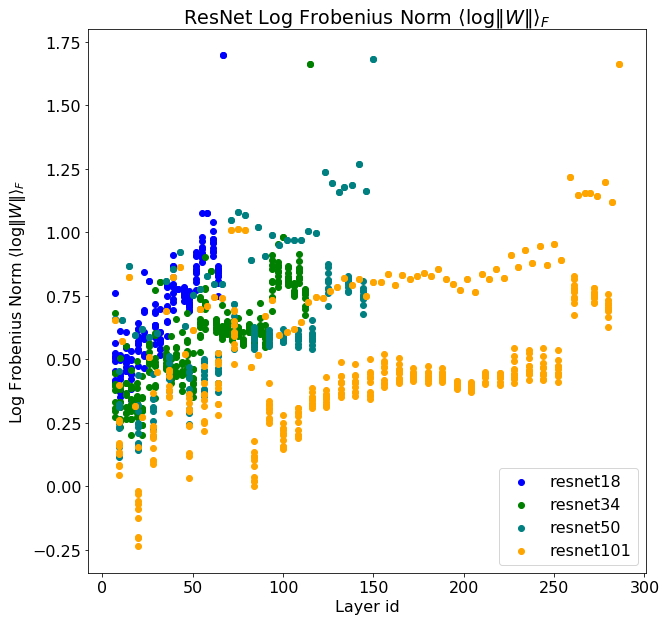

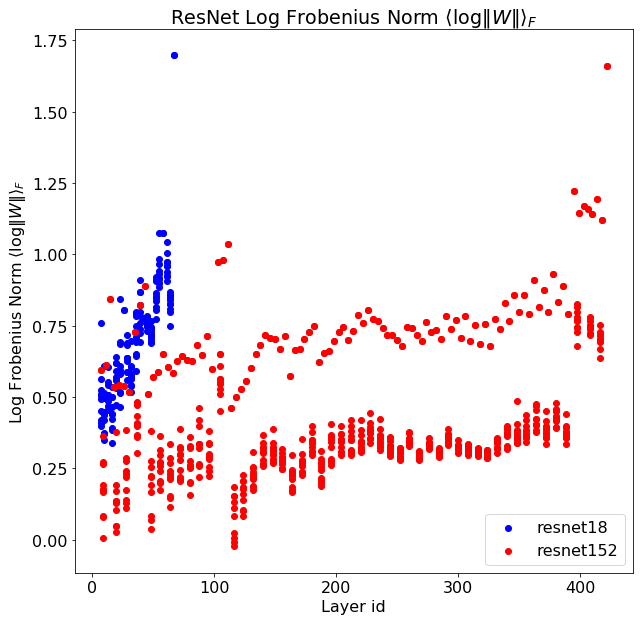

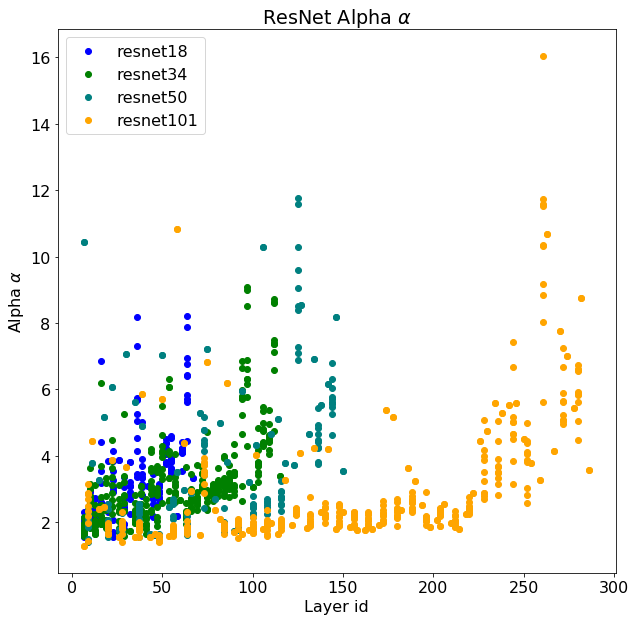

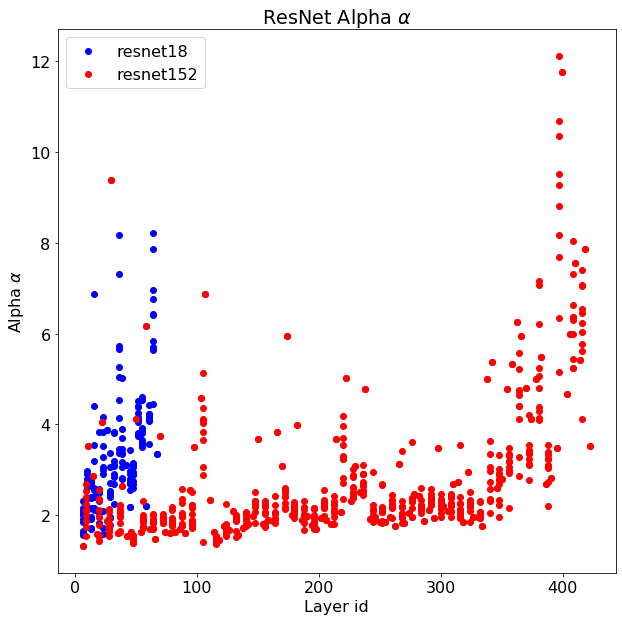

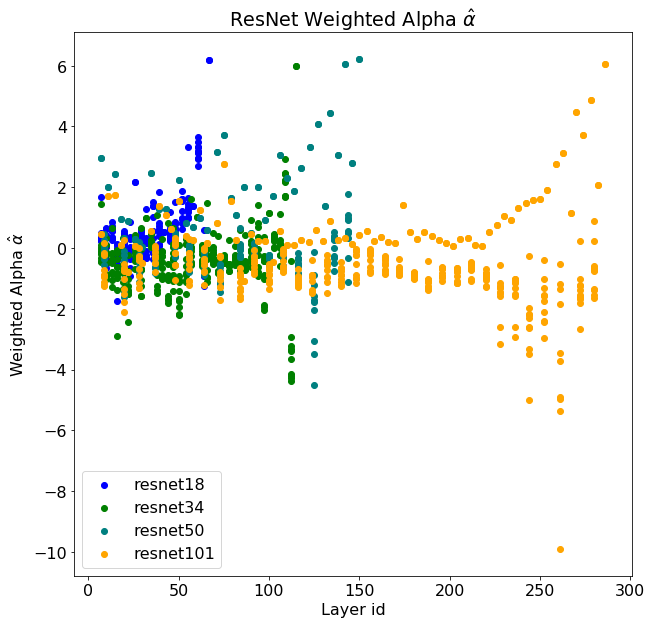

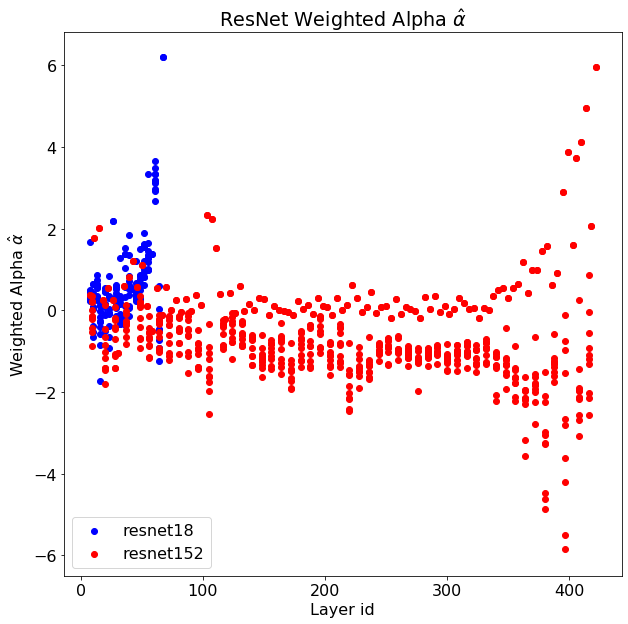

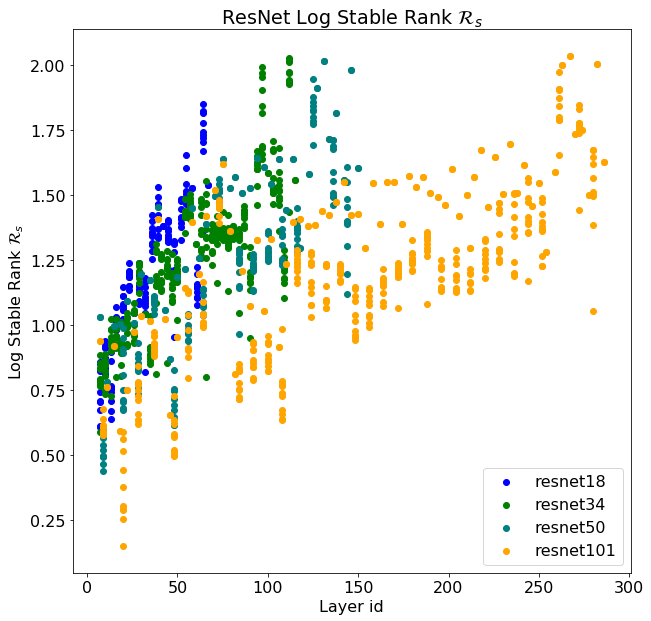

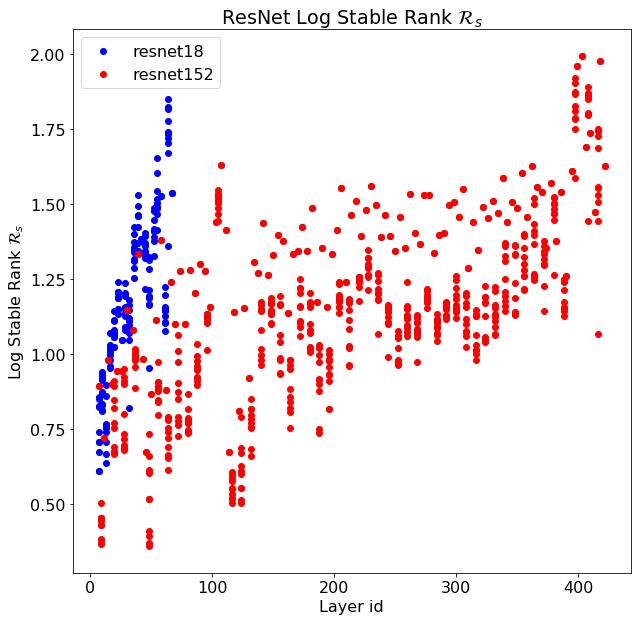

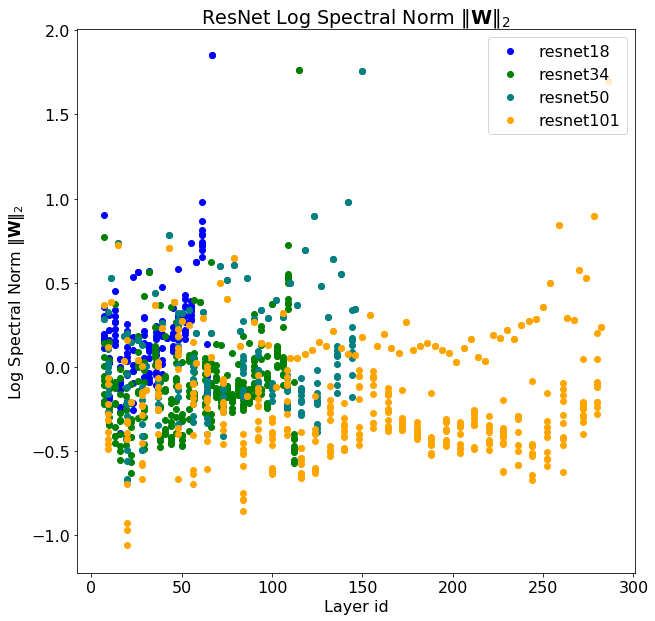

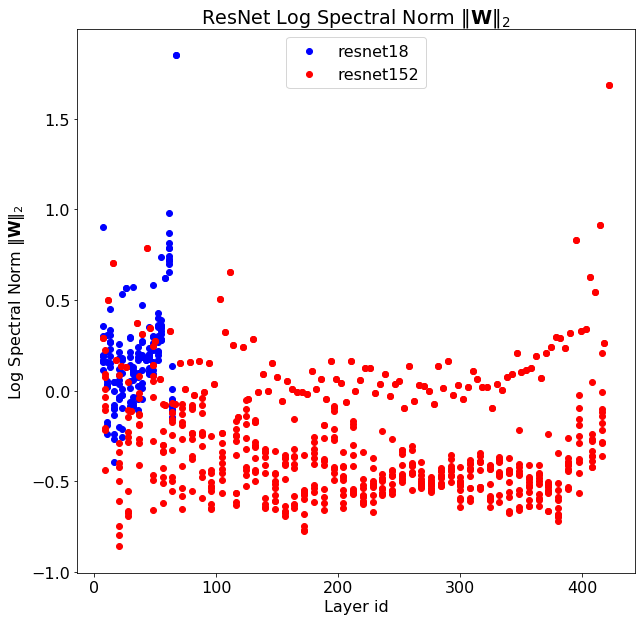

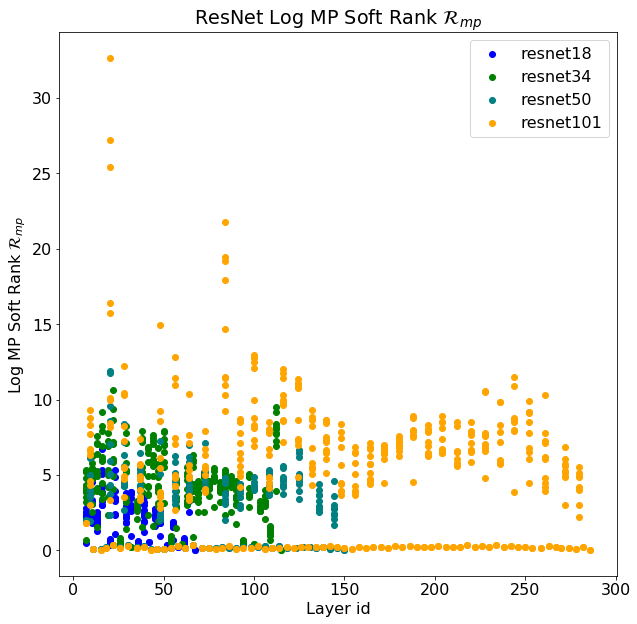

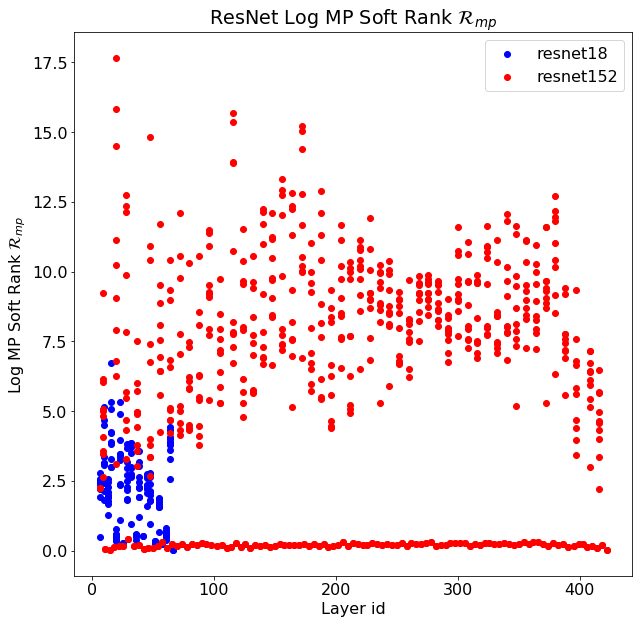

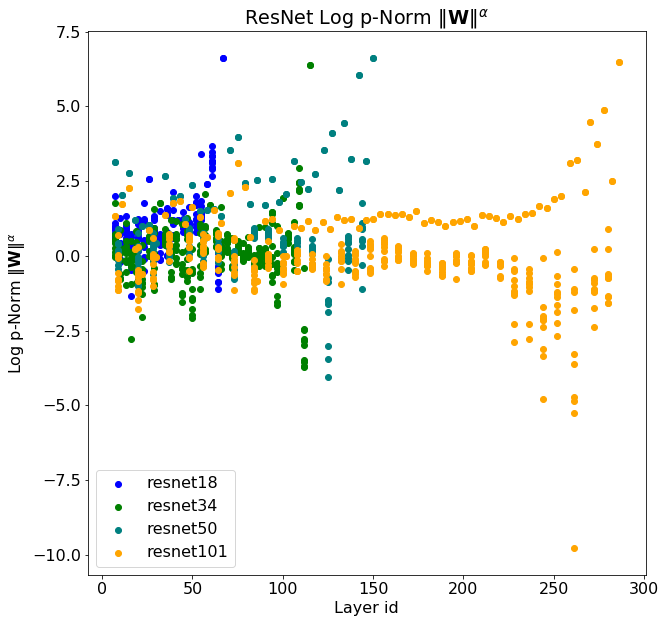

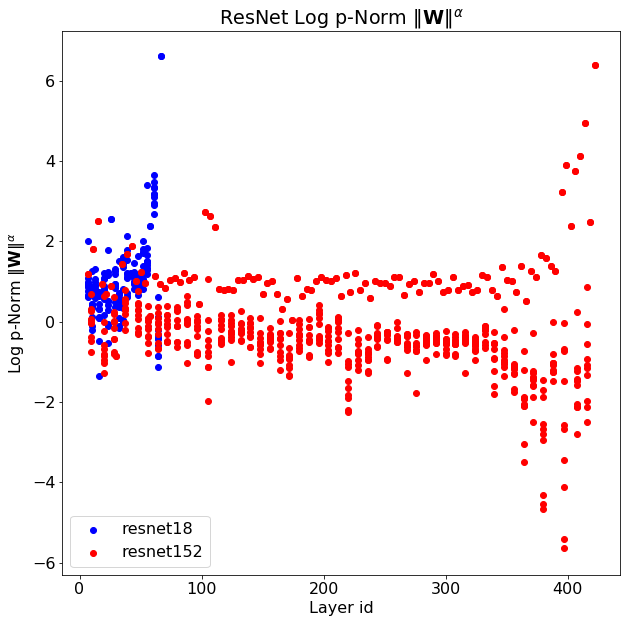

In [283]:
first_n_last_ids = [0, len(all_details)-1]
metric = "lognorm"
xlabel = r"Log Frobenius Norm $\langle\log\Vert W\Vert\rangle_{F}$"
title = series_name+" "+xlabel
plot_metrics_depth(metric, xlabel, title)
plot_metrics_depth(metric, xlabel, title, valid_ids = first_n_last_ids)


metric = "alpha"
xlabel = r"Alpha $\alpha$"
title = series_name+" "+xlabel
plot_metrics_depth(metric, xlabel, title)
plot_metrics_depth(metric, xlabel, title, valid_ids = first_n_last_ids)


metric = "alpha_weighted"
xlabel = r"Weighted Alpha $\hat{\alpha}$"
title = series_name+" "+xlabel
plot_metrics_depth(metric, xlabel, title)
plot_metrics_depth(metric, xlabel, title, valid_ids = first_n_last_ids)



metric = "softranklog"
xlabel = r"Log Stable Rank $\mathcal{R}_{s}$"
title = series_name+" "+xlabel
plot_metrics_depth(metric, xlabel, title)
plot_metrics_depth(metric, xlabel, title, valid_ids = first_n_last_ids)


metric = "spectralnorm"
xlabel = r"Log Spectral Norm $\Vert\mathbf{W}\Vert_{2}$"
title = series_name+" "+xlabel
plot_metrics_depth(metric, xlabel, title, log=True)
plot_metrics_depth(metric, xlabel, title, log=True, valid_ids = first_n_last_ids)


metric = "softrank_mp"
xlabel = r"Log MP Soft Rank $\mathcal{R}_{mp}$"
title = series_name+" "+xlabel
plot_metrics_depth(metric, xlabel, title)
plot_metrics_depth(metric, xlabel, title, valid_ids = first_n_last_ids)

metric = "logpnorm"
xlabel = r"Log p-Norm $\Vert\mathbf{W}\Vert^{\alpha}$"
title = series_name+" "+xlabel
plot_metrics_depth(metric, xlabel, title)
plot_metrics_depth(metric, xlabel, title, valid_ids = first_n_last_ids)